***Credit Card Fraud Detection using LightGBM Model***

**Importing Necessary Libraries**

In [5]:
import os
import csv
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

from lightgbm import LGBMClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.metrics import classification_report_imbalanced

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GroupKFold, StratifiedKFold
from sklearn.metrics import (matthews_corrcoef, roc_auc_score,
                             average_precision_score, f1_score)

from sklearn.experimental import enable_halving_search_cv # noqa
from sklearn.model_selection import HalvingGridSearchCV

**Set Seed for Reproducability**

In [6]:
SEED = 1
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

Boolean value to control whether to use previous grid search result or perform new search

In [7]:
USE_TUNED_PARAMS = True

**Loading the Data**

Using customized read_csv() to optimize datatypes and minimize memory usage

In [8]:
def read_csv(file_path: str, nrows=None, dtype=np.float32) -> pd.DataFrame:
    with open(file_path, 'r') as f:
        column_names = next(csv.reader(f))
    dtypes = {x: dtype for x in column_names if
            x != 'Class'}
    dtypes['Class'] = np.int8
    return pd.read_csv(file_path, nrows=nrows, dtype=dtypes)

In [9]:
filePath = '/home/punnoose1997/Documents/Ophir Projects/Credit Card Fraud Detection - LightGBM Model/creditcard.csv'
df = read_csv(filePath)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float32
 1   V1      284807 non-null  float32
 2   V2      284807 non-null  float32
 3   V3      284807 non-null  float32
 4   V4      284807 non-null  float32
 5   V5      284807 non-null  float32
 6   V6      284807 non-null  float32
 7   V7      284807 non-null  float32
 8   V8      284807 non-null  float32
 9   V9      284807 non-null  float32
 10  V10     284807 non-null  float32
 11  V11     284807 non-null  float32
 12  V12     284807 non-null  float32
 13  V13     284807 non-null  float32
 14  V14     284807 non-null  float32
 15  V15     284807 non-null  float32
 16  V16     284807 non-null  float32
 17  V17     284807 non-null  float32
 18  V18     284807 non-null  float32
 19  V19     284807 non-null  float32
 20  V20     284807 non-null  float32
 21  V21     28

In [10]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.619995,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.690000,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.660004,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.500000,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798279,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.989998,0


**Data Exploration**

In [11]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.867188,1.339397e-08,0.000000,-4.800400e-08,6.643411e-09,2.657364e-08,-1.500125e-09,-1.071518e-09,-1.071518e-10,-3.214554e-10,...,-1.928732e-09,3.643161e-09,3.214554e-10,1.259033e-09,2.143036e-09,1.034684e-09,1.138488e-10,-1.272427e-10,88.349609,0.001727
std,47488.144531,1.958696e+00,1.651309,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120117,0.041527
min,0.000000,-5.640751e+01,-72.715729,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-0.598550,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,0.065486,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097605e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,0.803724,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273458e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165001,0.000000
max,172792.000000,2.454930e+00,22.057730,9.382559e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519588e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160156,1.000000


Check for any missing values

In [12]:
df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Make a copy to modify and visualise

In [13]:
df_copy = df.copy()

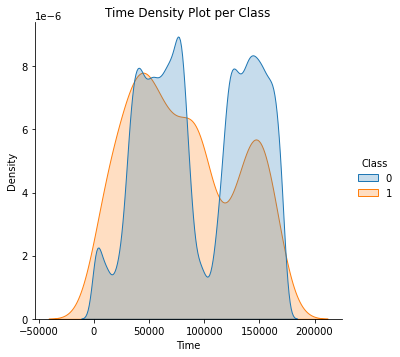

In [14]:
ax = sns.displot(df_copy, x='Time', hue='Class', kind='kde', fill=True, common_norm=False)
ax.set(title='Time Density Plot per Class')

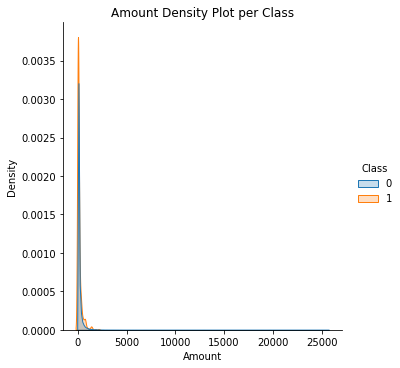

In [15]:
ax = sns.displot(df_copy, x='Amount', hue='Class', kind='kde', fill=True, common_norm=False)
ax.set(title='Amount Density Plot per Class')

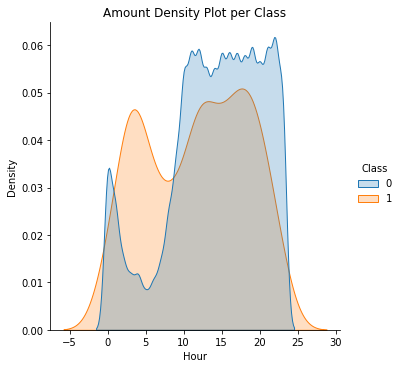

In [16]:
df_copy['Hour'] = df_copy['Time'].apply(lambda x: np.ceil(x / 3600) % 24)

ax = sns.displot(df_copy, x='Hour', hue='Class', kind='kde', fill=True, common_norm=False)
ax.set(title='Amount Density Plot per Class')

In [17]:
tmp = df_copy.groupby(['Hour', 'Class'])['Amount'].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()
stats = pd.DataFrame(tmp)
stats.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']
stats.head()

,Hour,Class,Min,Max,Transactions,Sum,Mean,Median,Var
0,0.0,0,0.0,10199.440430,10919,750813.937500,68.762154,14.400000,46255.160156
1,0.0,1,0.0,512.250000,21,3143.119873,149.672379,42.529999,31753.310547
2,1.0,0,0.0,7712.430176,7687,462282.281250,60.138191,12.140000,33692.777344
3,1.0,1,0.0,829.409973,6,1820.069946,303.345001,230.239990,123876.718750
4,2.0,0,0.0,2481.600098,4212,263171.250000,62.481300,18.980000,21216.832031


Above, we plotted the volume of transactions per class grouped by hours of the day. Fraudulent Transactions have spikes in activity at specific hours and during usual sleeping hours.

/tmp/ipykernel_157391/172411016.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


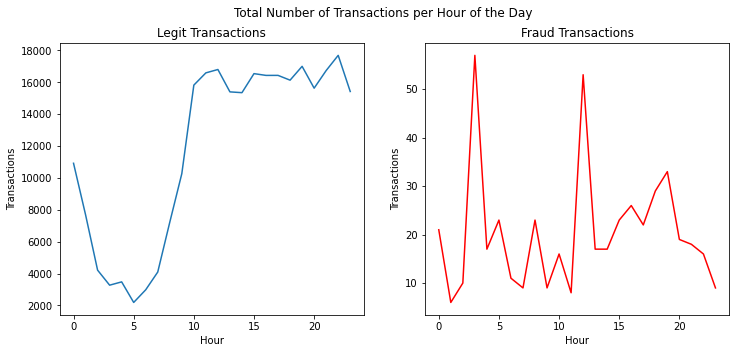

In [18]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.lineplot(x='Hour', y='Transactions', data=stats.query('Class == 0'), ax=ax[0])
sns.lineplot(x='Hour', y='Transactions', data=stats.query('Class == 1'), color='red', ax=ax[1])
fig.suptitle('Total Number of Transactions per Hour of the Day')
ax[0].set(title='Legit Transactions')
ax[1].set(title='Fraud Transactions')
fig.show()

**Data Preparation**

To avoid overfitting, adjust model parameters progressively by incrementally increase the fraction of data by 20%

In [19]:
df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)

In [20]:
y = df['Class']
X = df.drop('Class', axis=1)

feature_names = X.columns.tolist()

In [21]:
y.value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

From above result, data is unbalanced. Less than 1% positive fraudulent examples

From loaded data, we split the data into training and testing sets using the 80-20 rule

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=SEED)

**Feature Engineering**

Calculate additional features containing statistical information about anonymized values

In [23]:
def get_group_stats(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create features by calculating statistical moments.
    
    :param df: Pandas DataFrame containing all features
    """
    cols = list(filter(lambda x: x.startswith('V'), df.columns))
    
    # avoid warnings about returning-a-view-versus-a-copy
    ds = df.copy()
    
    ds['V_mean'] = df[cols].mean(axis=1)
    ds['V_std'] = df[cols].std(axis=1)
    ds['V_skew'] = df[cols].skew(axis=1)
    
    return ds

X_train = get_group_stats(X_train)
X_test = get_group_stats(X_test)

In [24]:
X_train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,V_mean,V_std,V_skew
9319,101691.0,2.113122,-0.067427,-1.062211,0.183495,0.154411,-0.585322,-0.166365,-0.246107,1.995113,...,0.439633,-1.133765,-0.631077,0.046039,-0.101130,-0.065391,9.91,-0.054216,1.051117,-0.050505
210502,72620.0,1.143742,0.174741,0.862678,1.052988,-0.666547,-0.569471,-0.211694,0.059470,0.007118,...,0.127981,0.469585,0.219076,-0.651484,0.028700,0.026081,9.99,0.145706,0.572725,0.400858
51455,141717.0,-1.502364,1.635901,-0.646716,0.359882,0.136560,-1.127764,0.249920,0.705085,0.144000,...,-0.158949,-0.092972,0.533375,-0.573315,-0.318169,-0.041170,1.99,-0.236430,0.796273,0.079623
128284,104458.0,-0.580486,0.721799,-1.554297,-1.735136,-0.122013,-0.069607,3.386795,-0.889773,0.539206,...,-0.313510,0.815592,0.198952,0.883310,-0.015340,0.017878,400.00,0.114818,1.246032,0.522092
251996,111058.0,-3.715441,4.175828,-2.217402,-1.207024,-0.075184,-0.972042,0.425504,0.317196,4.090196,...,0.148733,0.492251,0.091003,-0.209533,2.023499,1.224342,0.89,0.399176,1.810966,0.338856


Training our model using Cross Validation. 

Using GroupKFold strategy to generate splits. 

Grouping is based on hour of the day of the given transaction since specific hours have more fraudulent transactions as per our previous plot

In [25]:
sfold = StratifiedKFold(n_splits=3)

hour_train = X_train['Time'].apply(lambda x: np.ceil(float(x) / 3600) % 24)

gfold = GroupKFold(n_splits=3)
groups = list(gfold.split(X_train, y_train, groups=hour_train))

In [26]:
def plot_correlation(corr: str) -> plt.Axes:
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [27]:
def select_features_correlation(df: pd.DataFrame) -> list:
    # Calculate correlations with target
    full_corr = df.corr(method='spearman')
    corr_with_target = full_corr['Class'].T.apply(abs).sort_values(ascending=False)
    
    min_threshold = corr_with_target.quantile(.25)
    
    # Select features with highest correlation to the target variable
    features_correlation = corr_with_target[corr_with_target >= min_threshold]
    features_correlation.drop('Class', inplace=True)
    return features_correlation.index.tolist()

Data is highly unbalanced. 

Obtaining Co-relation between some features is difficult. 

Undersampling the data to reduce the number of examples of the majority class gives a better co-relation. 

Use this co-relation amount to select higher co-related features with target class.

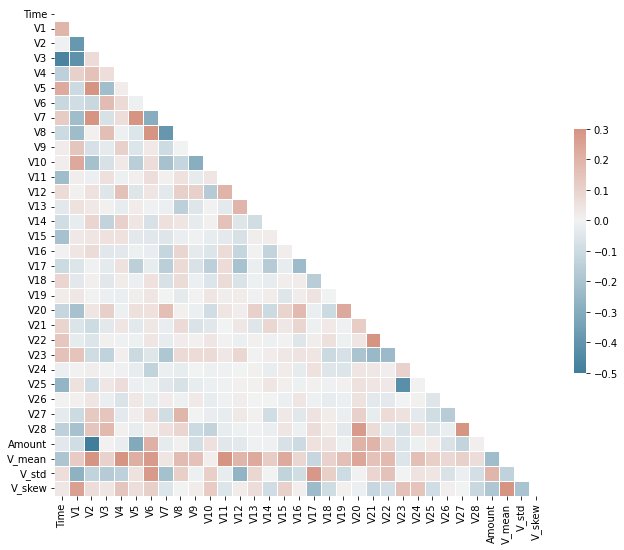

In [29]:
plot_correlation(X_train.corr(method='spearman'))

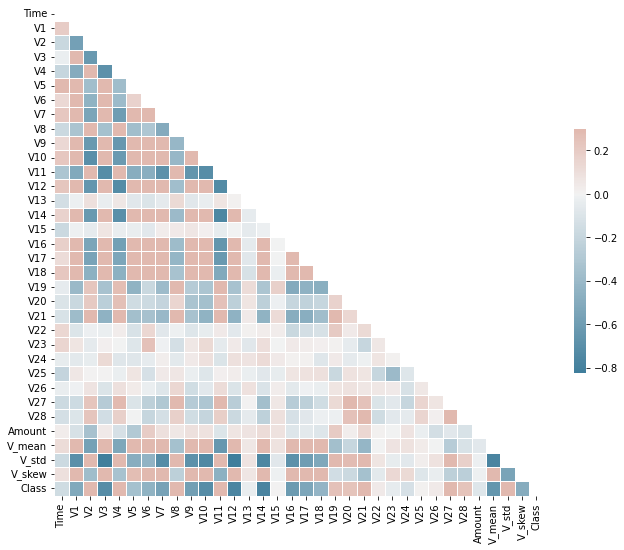

In [30]:
sampler = RandomUnderSampler(random_state=SEED)
X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
X_resampled['Class'] = y_resampled

plot_correlation(X_resampled.corr(method='spearman'))

Select features that have co-relation with target class, higher than the lower quartile value. For that, we drop features with low co-relation to help reduce the complexity

In [31]:
cols = select_features_correlation(X_resampled)
X_train = X_train[cols]
X_test = X_test[cols]

**Modelling**

Use Grid Search to tune hyperparameters of the model. Apply cross validation using GroupKFold as mentioned previously.

Performance Evaluation Method
- In this, false positives and false negatives are both relevant, so we use F1-score
- Accuracy alone can be misleading in this scenario
- Use maximum depth value to reduce chances of overfitting
- Test using different percentage of features used by each tree
- Try out 2 different learning rates
- Other params are kept to fine-tune alpha regularization value and sub-sample of the training set

**Baseline**

Train a simple baseline model for result reference

In [32]:
pipeline = Pipeline([
    ('standardscaler', StandardScaler()),
    ('clf', LGBMClassifier(n_jobs=-1, random_state=SEED)),
])

In [33]:
mcc_results = []
ap_results = []
roc_auc_results = []
f1_results = []

for train_index, test_index in groups:
    pipeline.fit(X_train.values[train_index], y_train.values[train_index])
    test_data = pipeline['standardscaler'].transform(X_train.values[test_index])
    
    y_pred = pipeline.predict(test_data)
    
    mcc_results.append(matthews_corrcoef(y_train.values[test_index], y_pred))
    ap_results.append(average_precision_score(y_train.values[test_index], y_pred))
    roc_auc_results.append(roc_auc_score(y_train.values[test_index], y_pred))
    f1_results.append(f1_score(y_train.values[test_index], y_pred))


print(f'Baseline MCC score: {np.mean(mcc_results)}')
print(f'Baseline AP score: {np.mean(ap_results)}')
print(f'Baseline ROC AUC score: {np.mean(roc_auc_results)}')
print(f'Baseline F1 score: {np.mean(f1_results)}')

Baseline MCC score: 0.14004205517311877
Baseline AP score: 0.026597984566692115
Baseline ROC AUC score: 0.7472040071954448
Baseline F1 score: 0.07980786840725138


**Fine Tuning**

In [35]:
gbm_grid = {
    'clf__n_estimators': [500, 1000],
    'clf__learning_rate': [0.1, 0.01],
    'clf__max_depth': [4, 6, 8],
    'clf__colsample_bytree': np.linspace(0.6, 1.0, num=5),
    'clf__reg_alpha': np.linspace(0., 1.0, num=5),
    'clf__subsample': np.linspace(0.7, 1.0, num=4),
}

In [36]:
def grid_search_tuning(pipeline, X, y, grid, fold):
    grid = HalvingGridSearchCV(pipeline, param_grid=grid, cv=fold, scoring='f1',
                               random_state=SEED, n_jobs=-1, verbose=1)
    grid.fit(X, y)
    
    print(f"\nMean test score: {np.mean(grid.cv_results_['mean_test_score'])}")
    print(f'Best parameters: {grid.best_params_}')
    
    return grid.best_estimator_

In [37]:
if USE_TUNED_PARAMS:
    print('Using previously tuned model parameters.')
    
    best_params = {
        'n_estimators': 500,
        'learning_rate': 0.01,
        'max_depth': 8,
        'colsample_bytree': 0.6,
    }
    
    pipeline = Pipeline([
        ('standardscaler', StandardScaler()),
        ('clf', LGBMClassifier(**best_params, n_jobs=-1, random_state=SEED)),
    ])
    
    grid = pipeline.fit(X_train, y_train)
else:
    pipeline = Pipeline([
        ('standardscaler', StandardScaler()),
        ('clf', LGBMClassifier(n_jobs=-1, random_state=SEED)),
    ])

    # It can take a while to run
    grid = grid_search_tuning(pipeline, X_train, y_train, gbm_grid, groups)

Using previously tuned model parameters.


Model's performance evaluation on the test set and feature importance.

In [38]:
def score_model(clf, X_test, y_test, feature_names):
    y_pred = clf.predict(X_test)
    y_probas = clf.predict_proba(X_test)

    print(classification_report_imbalanced(y_test, y_pred, target_names=['Legit', 'Fraud']))
    print(f'MCC: {matthews_corrcoef(y_test, y_pred)}\nAP: ' +
          f'{average_precision_score(y_test, y_pred)}\nROC AUC: {roc_auc_score(y_test, y_pred)}')

    fig, ax = plt.subplots(1,2, figsize=(12,5))
    skplt.metrics.plot_precision_recall(y_test, y_probas, ax=ax[0])
    skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, ax=ax[1])
    fig.show()
    
    skplt.estimators.plot_feature_importances(clf, feature_names=feature_names, figsize=(16,5))

    return y_probas

                   pre       rec       spe        f1       geo       iba       sup

      Legit       1.00      1.00      0.81      1.00      0.90      0.82     56864
      Fraud       0.94      0.81      1.00      0.87      0.90      0.79        98

avg / total       1.00      1.00      0.81      1.00      0.90      0.82     56962

MCC: 0.8705096324464109
AP: 0.7584725255774664
ROC AUC: 0.9030172599428067


/tmp/ipykernel_157391/2537049574.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


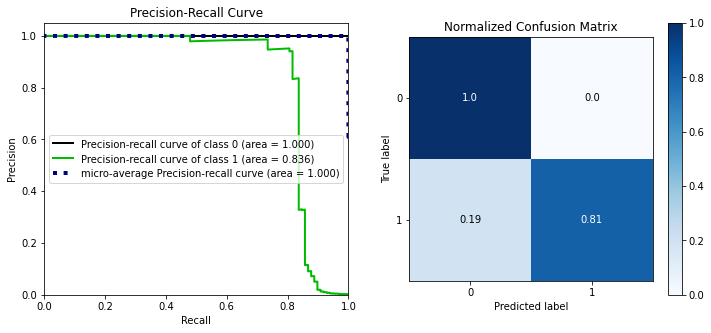

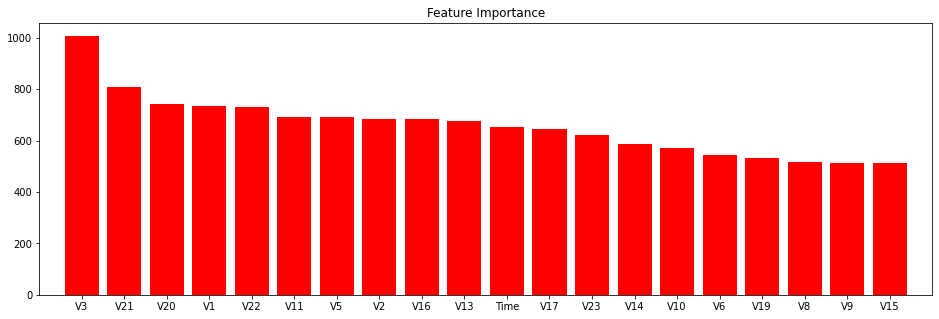

In [39]:
scaled_X_test = grid['standardscaler'].transform(X_test)

y_probas = score_model(grid['clf'], scaled_X_test, y_test, feature_names)

<AxesSubplot:title={'center':'Calibration plots (Reliability Curves)'}, xlabel='Mean predicted value', ylabel='Fraction of positives'>

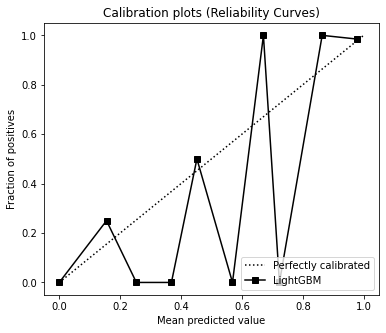

In [40]:
skplt.metrics.plot_calibration_curve(y_test, [y_probas], ['LightGBM'], figsize=(6,5))

<AxesSubplot:title={'center':'Learning Curve'}, xlabel='Training examples', ylabel='Score'>

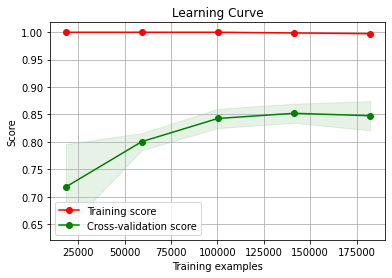

In [41]:
skplt.estimators.plot_learning_curve(grid['clf'], X_train, y_train, scoring='f1', n_jobs=-1, random_state=SEED)

**Conclusion**

- Resampling didn't produce good enough results
- Under sampling, over sampling and a combination of both didn't produce good enough results

**Possible Reasons**
- Most variables were from PCA transformations and this affected impact of sampling
- Low number of fraudulent transactions caused undersampling to produce a tiny data set too small to train a decent model

**Result of Model Testing**

In fraud detection, as mentioned previously, two cases are essential for a good model : achieve true positives(identify real fraudulent transactions) and avoid false positives(avoid labelling real transactions as fraudulent). The above model provides good results at achieving true positives with an F1 score of 0.87 and doesn't label any genuine transactions as fraudulent